# 多分类问题的混淆矩阵

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets

# 这里不再使用有偏的数据集
digits = datasets.load_digits()
X = digits.data
y = digits.target

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=666)

In [4]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9408901251738526

In [5]:
y_predict = log_reg.predict(X_test)

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 精准率，直接这样写会Error，目标是Multiclass
# 看提示信息：
# ValueError: Target is multiclass but average='binary'. 
# Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].
# 看precision_score 的文档: 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
try:
    precision_score(y_test, y_predict)
except Exception as e:
    print(e)

Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].


In [7]:
# 修改precision_score的参数, average="micro", recall, f1 score 同理
print(
    precision_score(y_test, y_predict, average="micro"),
    recall_score(y_test, y_predict, average="micro"),
    f1_score(y_test, y_predict, average="micro"),
)

0.9408901251738526 0.9408901251738526 0.9408901251738526


In [8]:
from sklearn.metrics import confusion_matrix
# 混淆矩阵天然就是支持多分类问题的，所以直接这样用就可以
confusion_matrix(y_test, y_predict)

array([[148,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0, 125,   2,   0,   0,   0,   0,   3,   2,  11],
       [  0,   1, 134,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   1, 138,   0,   5,   0,   1,   4,   0],
       [  2,   4,   0,   0, 138,   0,   1,   3,   0,   2],
       [  1,   2,   1,   0,   0, 146,   1,   0,   0,   1],
       [  0,   2,   0,   0,   0,   1, 132,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0, 135,   0,   1],
       [  0,   8,   2,   1,   3,   3,   0,   1, 120,   2],
       [  0,   1,   0,   6,   0,   1,   0,   1,   1, 137]], dtype=int64)

混淆矩阵天然就是支持多分类问题的, 这里的解读方法依然不变，与2x2的矩阵的解读方式一致。  
对于第i行，第j列来说：  
* 行方向依然是，依然是真值，真值为i
* 列方向依然是，依然是预测值，预测为j的样本数  
数字最大的在对角线的位置，对角线的上的元素，$i$与$j$相等，所以这个数字代表着，真值为$i$，预测值为$i$($=j$,预测正确)的数量。    
除了对角线以外，就是错误的。  
一个直观的观察错误的方法，是把每一个值当作一个颜色的值，0为黑色，则：

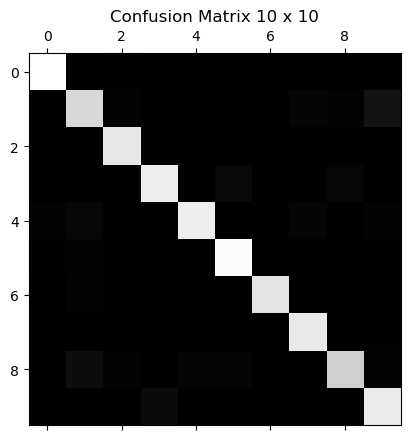

In [11]:
cfm = confusion_matrix(y_test, y_predict)
plt.matshow(cfm, cmap=plt.cm.gray)
plt.title("Confusion Matrix 10 x 10")
plt.show()

越亮的地方，数值越大，反之越小。这个图就表示了，预测的大多数样本是正确的。  
只关注正确的部分是没意义的，想找到的是错误的在哪儿：  
1. 计算出每一行都都有多少个样本，保存到变量row_sums(matrix)中
2. 用cfm的每一行的数字除以行样本总数，得到一个百分比，保存到err_matrix中
3. 我们不关注那些完全预测正确的结果，使用np.fill_diagonal将对角线的位置数字填写为0
4. plot错误矩阵(err_matrix)

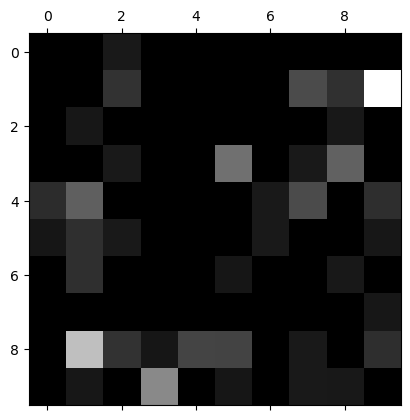

In [10]:
row_sums = np.sum(cfm, axis=1)
err_matrix = cfm / row_sums
np.fill_diagonal(err_matrix, 0)

plt.matshow(err_matrix, cmap=plt.cm.gray)
plt.show()

这个结果反应的就是，对于这个多分类问题的模型来说，越亮的地方就是犯错越多的地方。  
* 在$(1, 9)$处（左上角），有一个非常亮的白格子，意思是真值为1，但是预测值是9的位置，这代表着模型将很多真值为1的样本预测成了9。
* 同理在$(8 ,1)$的地方也有一个比较量的格子，表示，把一些真值为8的样本预测成了1
通过这个方法，将模型具体犯错，具体是什么错误的地方可视化。有了这个提示，就可以进一步的修改算法。本案例中，可以发现模型很容易混淆1与8，1与9，那么就可以人为的去干预1和8，1和9这两个2分类问题中的那个threshold，来提高多分类问题的准确度。  

另外，在这个笔记中，更注重的机器学习算法本身，很多时候一个模型的失败，其原因可能并不在于算法本身，有可能在样本数据的层面上，在真实的环境中遇到这样的Error Matrix时，应该把样本为1，样本为8，样本为9的图片拿出来再看一看，很有可能样本数据也有一些问题。即使样本数据没有问题，通过观察也可以发现存在于样本数据之中的新的特征，这些都是属于特征工程，对数据的处理的相关内容，不在本笔记的负责范围中。  

所以在面对模型的失败的时候不仅仅要思考算法，还需要回头看看数据，统计，等过程。看看能不能更好的清理数据，统计数据等，这也是在机器学习中至关重要的内容。